### Try it 10.1: Decomposing Time Series


<center>
    <img src = 'images/spots.png' /><img src = 'images/air.png' />
</center>


 

This activity fouses on exploring two different time series and the decomposed elements.  The example of sunspots data is given as well as a dataset containing air passenger information through the twentieth century in the United States.  These are both time series datasets however there is a distinct difference in the nature of the time series.  

Below, you are to use the statsmodels function `seasonal_decompose` to show how the trend and seasonality of the series differ in (perhaps) expected ways.  To begin, you are to make sure the datasets contain an appropriate time stamp index -- statsmodels expects this.  Then, use the `seasonal_decompose` function to decompose the series into trend and seasonality.  Examing plots of these elements, and discuss the similarities and differences between these components for the two time series.  

In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.seasonal import _extrapolate_trend

This notebook will be broken into two sections, the first analyzing the `sunpots` dataset, the second the `air` dataset. Each part will consist of the following steps:
- Initial data evaluation (visual inspection) to identify likely trends
- Trend extraction & examination of detrended data
- Seasonality extraction & esamination of seasonality data
- Examination of final residuals
- Plotting these elements (original dataset, trend, seasonality, residuals)
- Final discussion, if necessary

# Sunspots

In [2]:
sunspots = sm.datasets.sunspots.load_pandas()

In [3]:
ss = sunspots.data
ss.isna().sum()

YEAR           0
SUNACTIVITY    0
dtype: int64

In [4]:
ss.duplicated().sum()

0

In [5]:
ss_index = pd.to_datetime(ss.YEAR.astype(int), format='%Y')
ss = ss.drop('YEAR',axis=1).set_index(ss_index)
ss

,SUNACTIVITY
YEAR,
1700-01-01,5.0
1701-01-01,11.0
1702-01-01,16.0
1703-01-01,23.0
1704-01-01,36.0
...,...
2004-01-01,40.4
2005-01-01,29.8
2006-01-01,15.2


<Axes: xlabel='YEAR'>

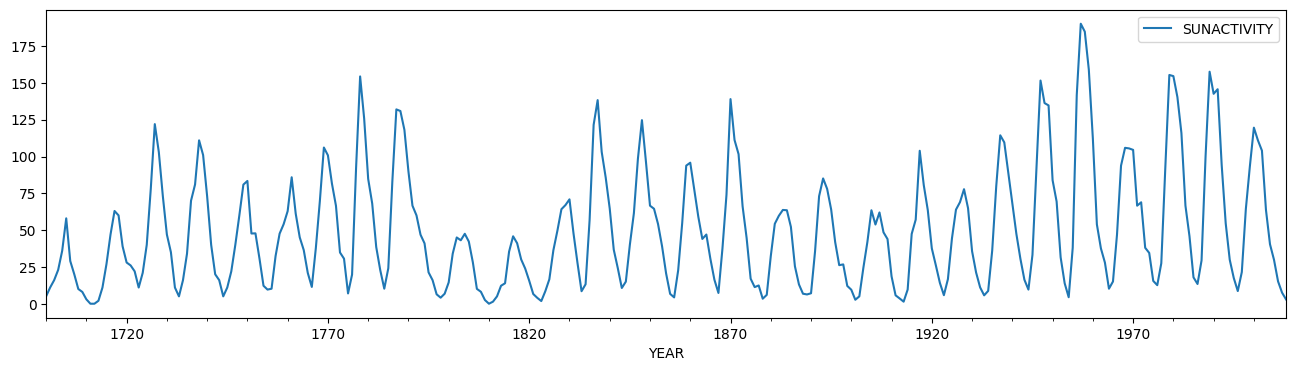

In [6]:
ss.plot(figsize=(16,4))

There is a clear seasonality here, although there are no clear trends. Within the seasonality there are some very high peaks and very low peaks; I wonder if this speaks to a second degree of seasonality that affects the data. We'll test for one and see how much error is left from the prediction. For sunspots, work will be manual; will use more automated methods for airlines.

## Trend

First, credate the filter, then run data through it and plot.

In [7]:
period = 11 # see seasonality section for this work; period is about 11 years
filt = np.ones(period+1)
filt[0] = 0.5
filt[-1] = 0.5
filt /= period
print(filt[[0, 1, 2, 3, 4, -5, -4, -3, -2, -1]]) # first and last five values; only first and last value different
sum(filt) # should equal 1

[0.04545455 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.04545455]


1.0000000000000002

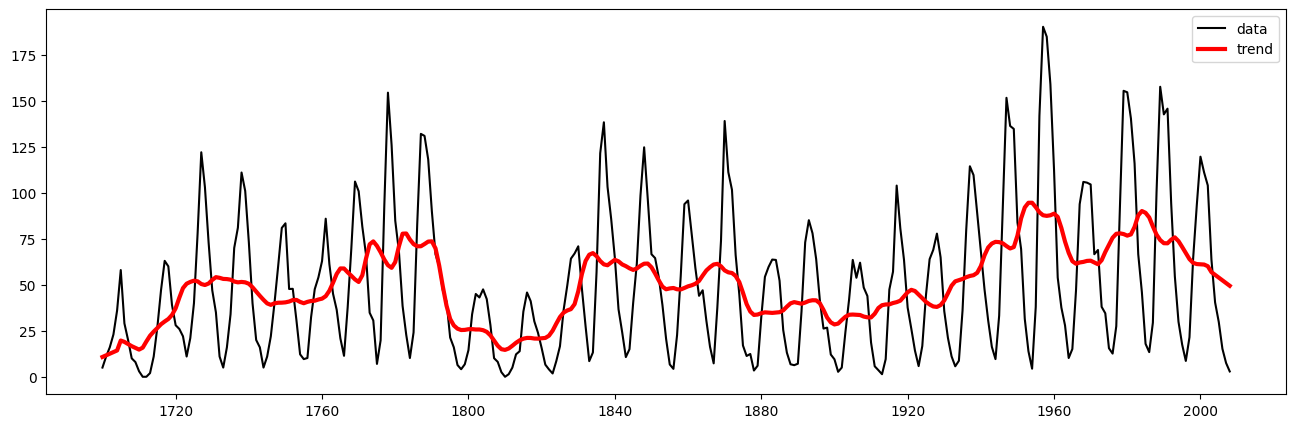

In [8]:
trend = convolution_filter(ss, filt) # apply filter (f) to time series data
trend = _extrapolate_trend(trend['SUNACTIVITY'], period + 1) # need to make `trend` a series; won't work with DataFrame

plt.figure(figsize=(16,5))
plt.plot(ss,'k',label='data')
plt.plot(trend,'r',linewidth=3,label='trend')
#plt.plot(y_future,'k',alpha=0.5)
plt.legend()

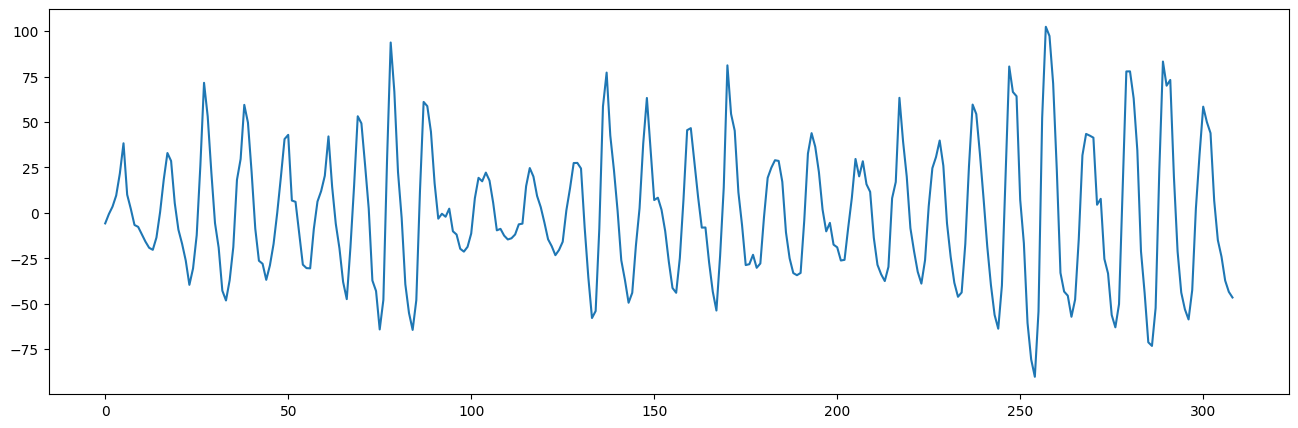

In [9]:
detrended = ss['SUNACTIVITY'] - trend
detrended = detrended.to_numpy()

plt.figure(figsize=(16,5))
plt.plot(detrended)

Almost looks like there's still some seasonality there, although the trend does seem to be zero now.

## Seasonality

In [10]:
# find local minima and maxima, and find the average distance between each subsequent trough/peak to find length of period
k = 8 # using 8 for either side to determine if point is minima for each season; this should be small enough not to worry
local_minima_index = []
local_maxima_index = []
minima_index = []
for i in range(8, len(ss)-8):
    #if i < k or i > (len(ss)-k):
    #    next
    temp_check = ss.iloc[i-k:i+k,0]
    temp_val = ss.iloc[i,0]
    if max(temp_check) == temp_val:
        local_maxima_index.append(ss.index[i])
    if min(temp_check) == temp_val:
        local_minima_index.append(ss.index[i])
        minima_index.append(i)

local_minima_index
#local_maxima_index

[Timestamp('1711-01-01 00:00:00'),
 Timestamp('1712-01-01 00:00:00'),
 Timestamp('1723-01-01 00:00:00'),
 Timestamp('1733-01-01 00:00:00'),
 Timestamp('1744-01-01 00:00:00'),
 Timestamp('1755-01-01 00:00:00'),
 Timestamp('1766-01-01 00:00:00'),
 Timestamp('1775-01-01 00:00:00'),
 Timestamp('1784-01-01 00:00:00'),
 Timestamp('1798-01-01 00:00:00'),
 Timestamp('1810-01-01 00:00:00'),
 Timestamp('1823-01-01 00:00:00'),
 Timestamp('1833-01-01 00:00:00'),
 Timestamp('1843-01-01 00:00:00'),
 Timestamp('1856-01-01 00:00:00'),
 Timestamp('1867-01-01 00:00:00'),
 Timestamp('1878-01-01 00:00:00'),
 Timestamp('1889-01-01 00:00:00'),
 Timestamp('1901-01-01 00:00:00'),
 Timestamp('1913-01-01 00:00:00'),
 Timestamp('1923-01-01 00:00:00'),
 Timestamp('1933-01-01 00:00:00'),
 Timestamp('1944-01-01 00:00:00'),
 Timestamp('1954-01-01 00:00:00'),
 Timestamp('1964-01-01 00:00:00'),
 Timestamp('1976-01-01 00:00:00'),
 Timestamp('1986-01-01 00:00:00'),
 Timestamp('1996-01-01 00:00:00')]

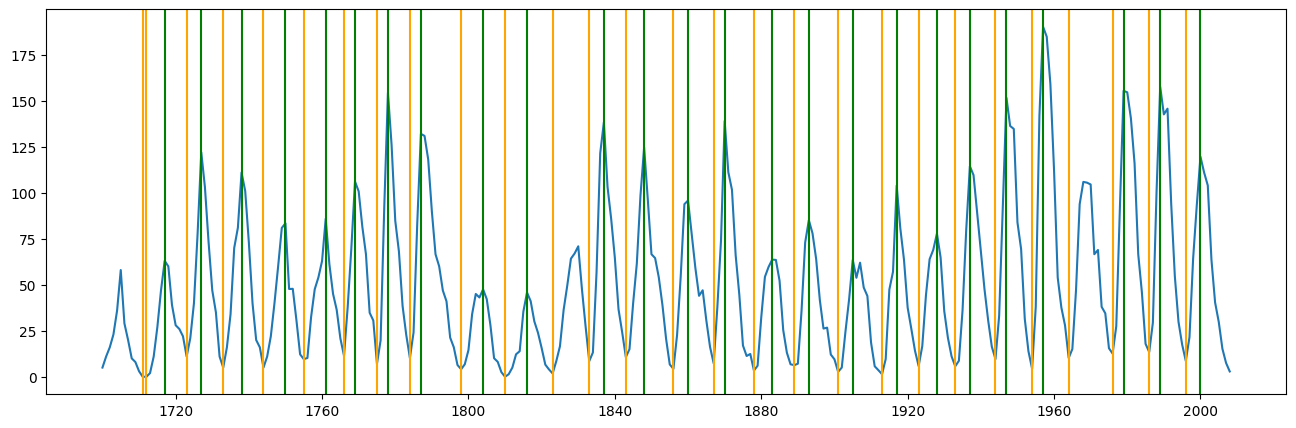

In [11]:
plt.figure(figsize=(16,5))
plt.plot(ss)
for minima in local_minima_index:
    plt.axvline(x=minima, color = 'orange')
for maxima in local_maxima_index:
    plt.axvline(x=maxima, color = 'green')

In [12]:
# remove first minima; two of same
del local_minima_index[0]
del minima_index[0]

pd.DataFrame({'lmi': local_minima_index, 'mi': minima_index})

,lmi,mi
0,1712-01-01,12
1,1723-01-01,23
2,1733-01-01,33
3,1744-01-01,44
4,1755-01-01,55
5,1766-01-01,66
6,1775-01-01,75
7,1784-01-01,84
8,1798-01-01,98
9,1810-01-01,110


In [13]:
np.diff(minima_index)
# Differences in period lengths... will have to round, and results won't be as clean

array([11, 10, 11, 11, 11,  9,  9, 14, 12, 13, 10, 10, 13, 11, 11, 11, 12,
       12, 10, 10, 11, 10, 10, 12, 10, 10])

In [14]:
period = int(np.round(np.mean(np.diff(minima_index))))
lows = ss.loc[local_minima_index,:]
num_seasons = len(lows)-1
period, num_seasons, lows

(11,
 26,
             SUNACTIVITY
 YEAR                   
 1712-01-01          0.0
 1723-01-01         11.0
 1733-01-01          5.0
 1744-01-01          5.0
 1755-01-01          9.6
 1766-01-01         11.4
 1775-01-01          7.0
 1784-01-01         10.2
 1798-01-01          4.1
 1810-01-01          0.0
 1823-01-01          1.8
 1833-01-01          8.5
 1843-01-01         10.7
 1856-01-01          4.3
 1867-01-01          7.3
 1878-01-01          3.4
 1889-01-01          6.3
 1901-01-01          2.7
 1913-01-01          1.4
 1923-01-01          5.8
 1933-01-01          5.7
 1944-01-01          9.6
 1954-01-01          4.4
 1964-01-01         10.2
 1976-01-01         12.6
 1986-01-01         13.4
 1996-01-01          8.6)

In [15]:
seasonals = np.empty((period,num_seasons))
for p in range(num_seasons):
    s = detrended[minima_index[p]:minima_index[p]+period]
    s = 2*(s-np.min(s))/(np.max(s)-np.min(s))
    seasonals[:,p] = s
pd.DataFrame(seasonals) # seasonals: matrix; cols = seasons, rows = normalized observations

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.236741,0.143454,0.000000,0.000000,0.189817,0.284319,0.003162,0.000000,0.000000,0.000000,...,0.000000,0.080724,0.027564,0.168614,0.171963,0.309826,0.000000,0.000000,0.135499,0.000000
1,0.198309,0.294497,0.206081,0.199294,0.186638,0.769886,0.208611,0.260888,0.120427,0.032855,...,0.031980,0.093372,0.180145,0.468207,0.212891,0.588025,0.373643,0.187904,0.304452,0.266868
2,0.427364,0.600380,0.546453,0.494986,0.728841,1.347127,1.177914,1.217407,0.457872,0.139750,...,0.772299,0.698103,0.918508,1.156932,0.674889,1.291484,1.479656,0.849632,1.161492,1.228615
3,0.902383,1.240987,1.233953,0.925137,1.105069,2.000000,2.000000,2.000000,1.352917,0.423415,...,1.712408,1.265673,1.094029,1.645964,1.411760,2.000000,2.000000,1.765843,1.999338,2.000000
4,1.509608,2.000000,1.446791,1.418642,1.248567,1.933279,1.657450,1.963186,1.867656,0.443082,...,2.000000,2.000000,2.000000,1.789418,2.000000,1.836009,1.947371,2.000000,2.000000,1.830201
5,2.000000,1.691841,2.000000,1.941659,1.458932,1.543958,1.097781,1.737880,1.780054,1.491902,...,1.808466,1.671325,1.528653,2.000000,1.909894,1.808482,1.676154,1.981300,1.803189,1.870516
6,1.852421,1.177230,1.818412,2.000000,2.000000,1.133326,0.778455,1.286108,2.000000,2.000000,...,1.451680,1.957218,1.151647,1.676410,1.528104,1.140537,1.181913,1.958896,1.425030,1.188649
7,1.068409,0.710436,1.312500,1.094120,1.309304,0.459065,0.317544,0.975940,1.797826,1.762147,...,0.924410,1.522211,0.597519,0.939373,1.101536,0.860954,0.593836,1.225530,0.689531,0.665021
8,0.573405,0.485009,0.734797,1.076117,0.798320,0.360494,0.117786,1.018842,1.237299,1.218186,...,0.617397,1.378874,0.347308,0.511338,0.649829,0.347363,0.486973,1.290031,0.384055,0.375439
9,0.312068,0.090323,0.406250,0.645624,0.461486,0.000000,0.000000,0.992608,0.538574,0.904905,...,0.736830,0.511359,0.127151,0.180136,0.284065,0.111439,0.463466,0.632368,0.026474,0.257399


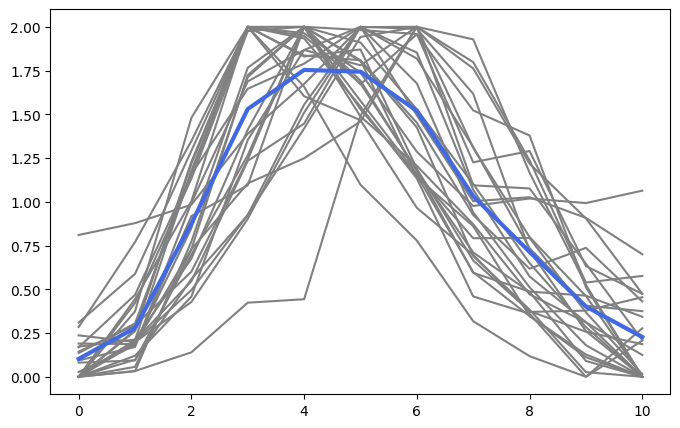

In [16]:
mean_seasonals = seasonals.mean(axis=1) # get the average for each time point in the season

plt.figure(figsize=(8,5))
for p in range(num_seasons):
    plt.plot(seasonals[:,p],color=.5*np.ones(3))
plt.plot(mean_seasonals,color='royalblue',linewidth=3)

A few outliers, which is altering the mean. Probably want to alter that a bit. How to find outliers? Add up sum of squares b/t each value in each seaonals and mean

In [17]:
MSD_seasonals = [] # MSD: Mean squared difference
for i in range(num_seasons):
    temp_season = seasonals[:,i]
    temp_MSD = (temp_season - mean_seasonals)**2
    MSD_seasonals.append(sum(temp_MSD))
pd.DataFrame(MSD_seasonals, columns=['MSD']).query('MSD > 1.5')

,MSD
5,1.555704
6,2.330245
7,1.592376
9,4.949792
10,2.268316


(array([ 7., 12.,  4.,  0.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([0.22640477, 0.6987435 , 1.17108223, 1.64342097, 2.1157597 ,
        2.58809843, 3.06043717, 3.5327759 , 4.00511463, 4.47745336,
        4.9497921 ]),
 <BarContainer object of 10 artists>)

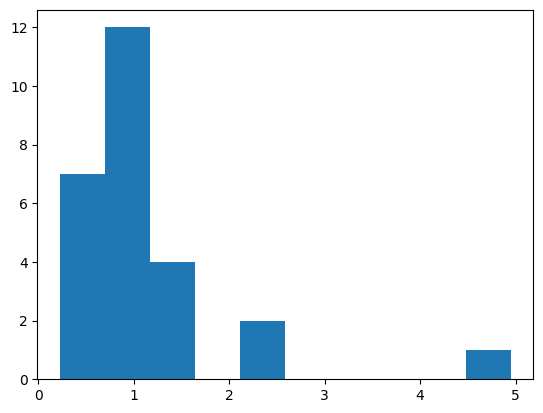

In [18]:
plt.hist(MSD_seasonals)

Remove anythihng with MSD over 1.5, then re-examine

In [19]:
seasonals_use = np.array(MSD_seasonals) > 1.5
seasonals_filter = np.array(list(range(0, len(MSD_seasonals))))[seasonals_use]
seasonals_filter

array([ 5,  6,  7,  9, 10])

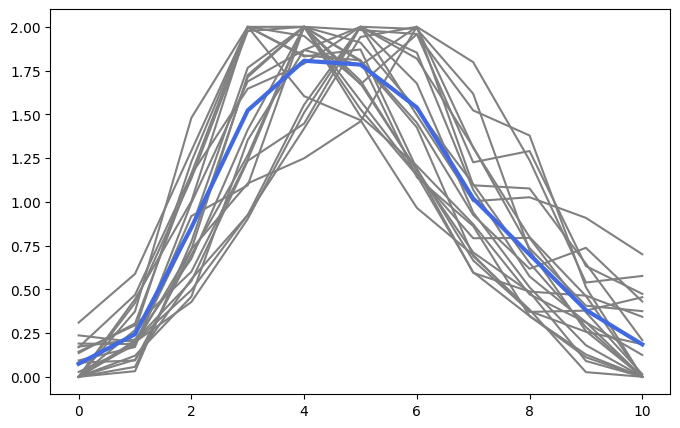

In [20]:
seasonals_filtered = np.delete(seasonals, [5,  6,  7,  9, 10], axis=1)
num_seasons_filtered = num_seasons-5
mean_seasonals_filtered = seasonals_filtered.mean(axis=1) # get the average for each time point in the season

plt.figure(figsize=(8,5))
for p in range(num_seasons_filtered):
    plt.plot(seasonals_filtered[:,p],color=.5*np.ones(3))
plt.plot(mean_seasonals_filtered,color='royalblue',linewidth=3)

Less crazy than before. Go with this.

## Build Seasonal Template

In [21]:
minima_index = [0] + minima_index
minima_index

[0,
 12,
 23,
 33,
 44,
 55,
 66,
 75,
 84,
 98,
 110,
 123,
 133,
 143,
 156,
 167,
 178,
 189,
 201,
 213,
 223,
 233,
 244,
 254,
 264,
 276,
 286,
 296]

C:\Users\matth\AppData\Local\Temp\ipykernel_65620\2087443393.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.07417205 0.242979   0.85257208 1.52222703 1.80570557 1.78384664
 1.5390853  1.01869645 0.69888073 0.38147257 0.1851256 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seasonal[low:low+period] = mean_seasonals_filtered


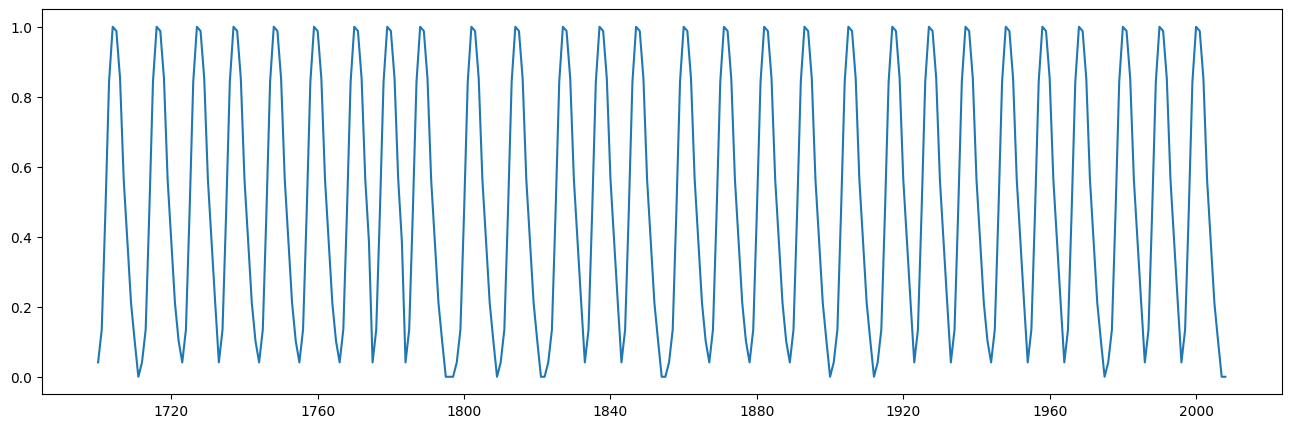

In [22]:
seasonal = pd.Series(index=ss.index,data=0) # create series with same index as time series data; all zeroes

for low in minima_index:
    if low+period<len(seasonal):
        seasonal[low:low+period] = mean_seasonals_filtered
    else:
        seasonal[low:] = mean_seasonals_filtered[:len(seasonal)-(low+period)]
        
seasonal = seasonal / np.max(seasonal)

plt.figure(figsize=(16,5))
plt.plot(seasonal)

Because the average season is not in fact 11 years, but usually a bit less, the seasonality trend does not usuallyshow a full cycle. Only at times when the seasonal length is equal to or greater than the rounded average (11) does the season dip all the way to zero, and sometimes stays there for a bit, reflecting the longer season period in the data.

## Model over historical data & get residue

Get residue

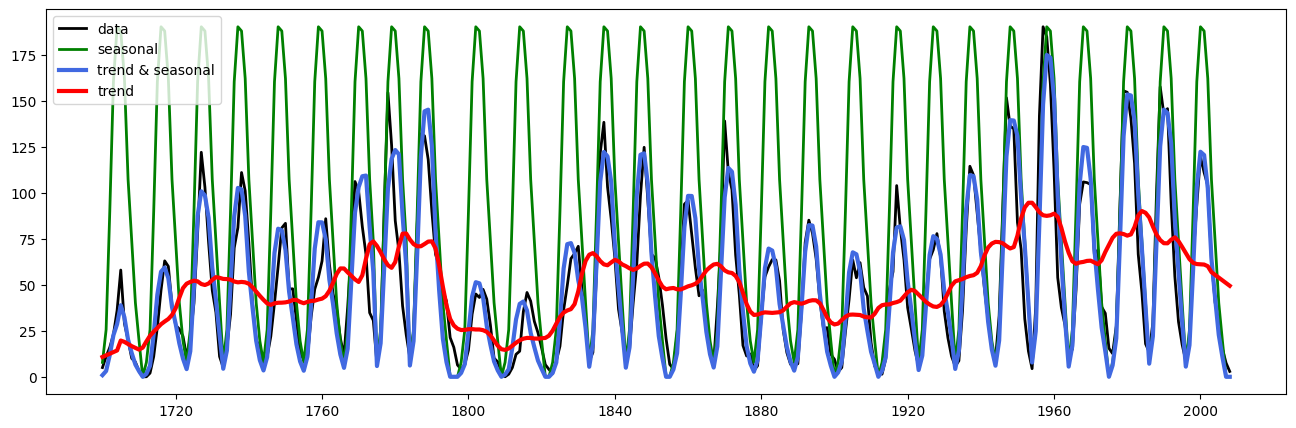

In [23]:
season_and_trend = 2*trend*seasonal

plt.figure(figsize=(16,5))
plt.plot(ss,'k',label='data',linewidth=2)
plt.plot(seasonal*max(ss['SUNACTIVITY']), label='seasonal', color='green', linewidth=2)
plt.plot(season_and_trend,label='trend & seasonal',color='royalblue',linewidth=3)
plt.plot(trend,label='trend',color='red',linewidth=3)
plt.legend()
#plt.savefig('images/sunspot-model.png', dpi=300)
plt.show()

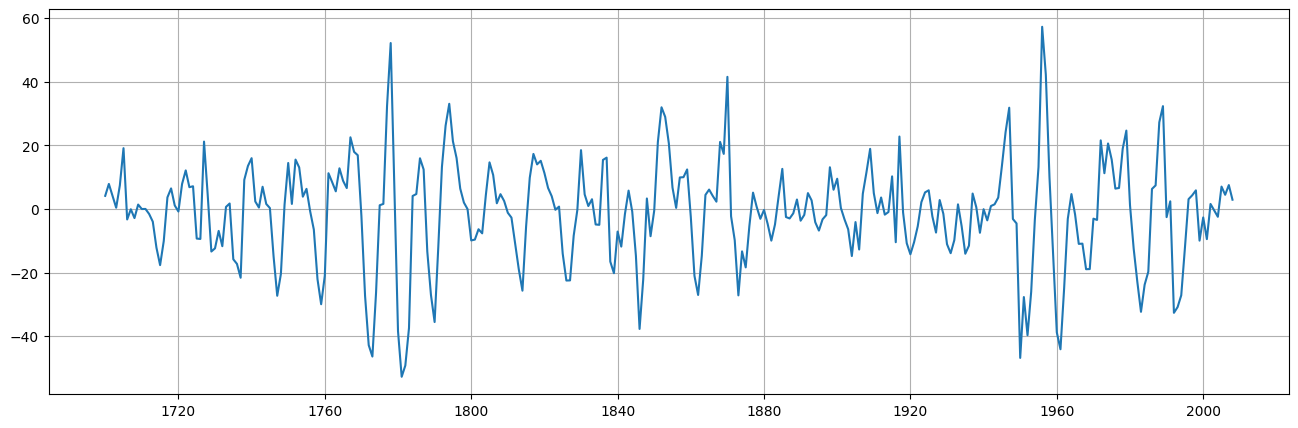

In [24]:
residue = ss['SUNACTIVITY'] - season_and_trend
plt.figure(figsize=(16,5))
plt.plot(residue)
plt.grid()

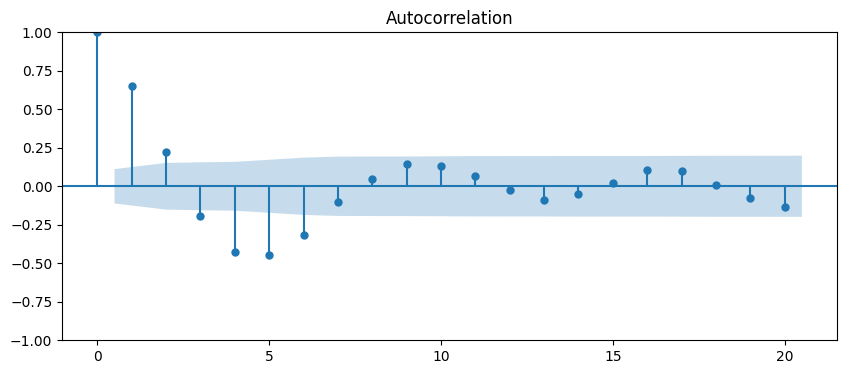

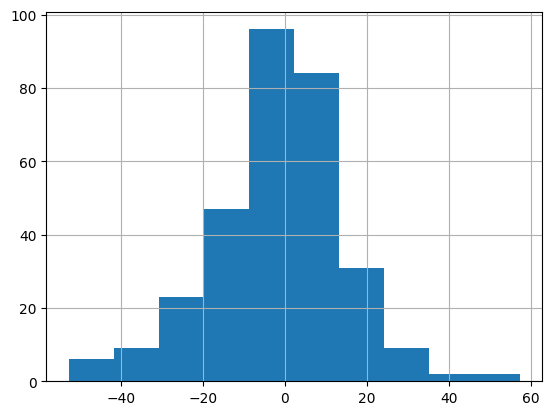

In [25]:
_, ax = plt.subplots(figsize=(10,4))
tsaplots.plot_acf(residue,lags=20, ax=ax)
plt.show()
residue.hist()
plt.show()

The residue seems to be stationary and is somewhat normally distributed, although possibly leptokurtic.

Plot everything for discussion

In [26]:
#fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(16, 8))
#ss['SUNACTIVITY'].plot(ax = axs[0], title = 'Sunspots', label = None) # Sunspots
#trend.plot(ax = axs[1], title = 'Trend') # Trend
#seasonal.plot(ax=axs[2], title = "Seasonality") # seasonality
#residue.plot(ax=axs[3], title = 'Residue') # residuals

#plt.savefig('images/sunspots_decomposition.png', dpi=300)
#plt.tight_layout()
#plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


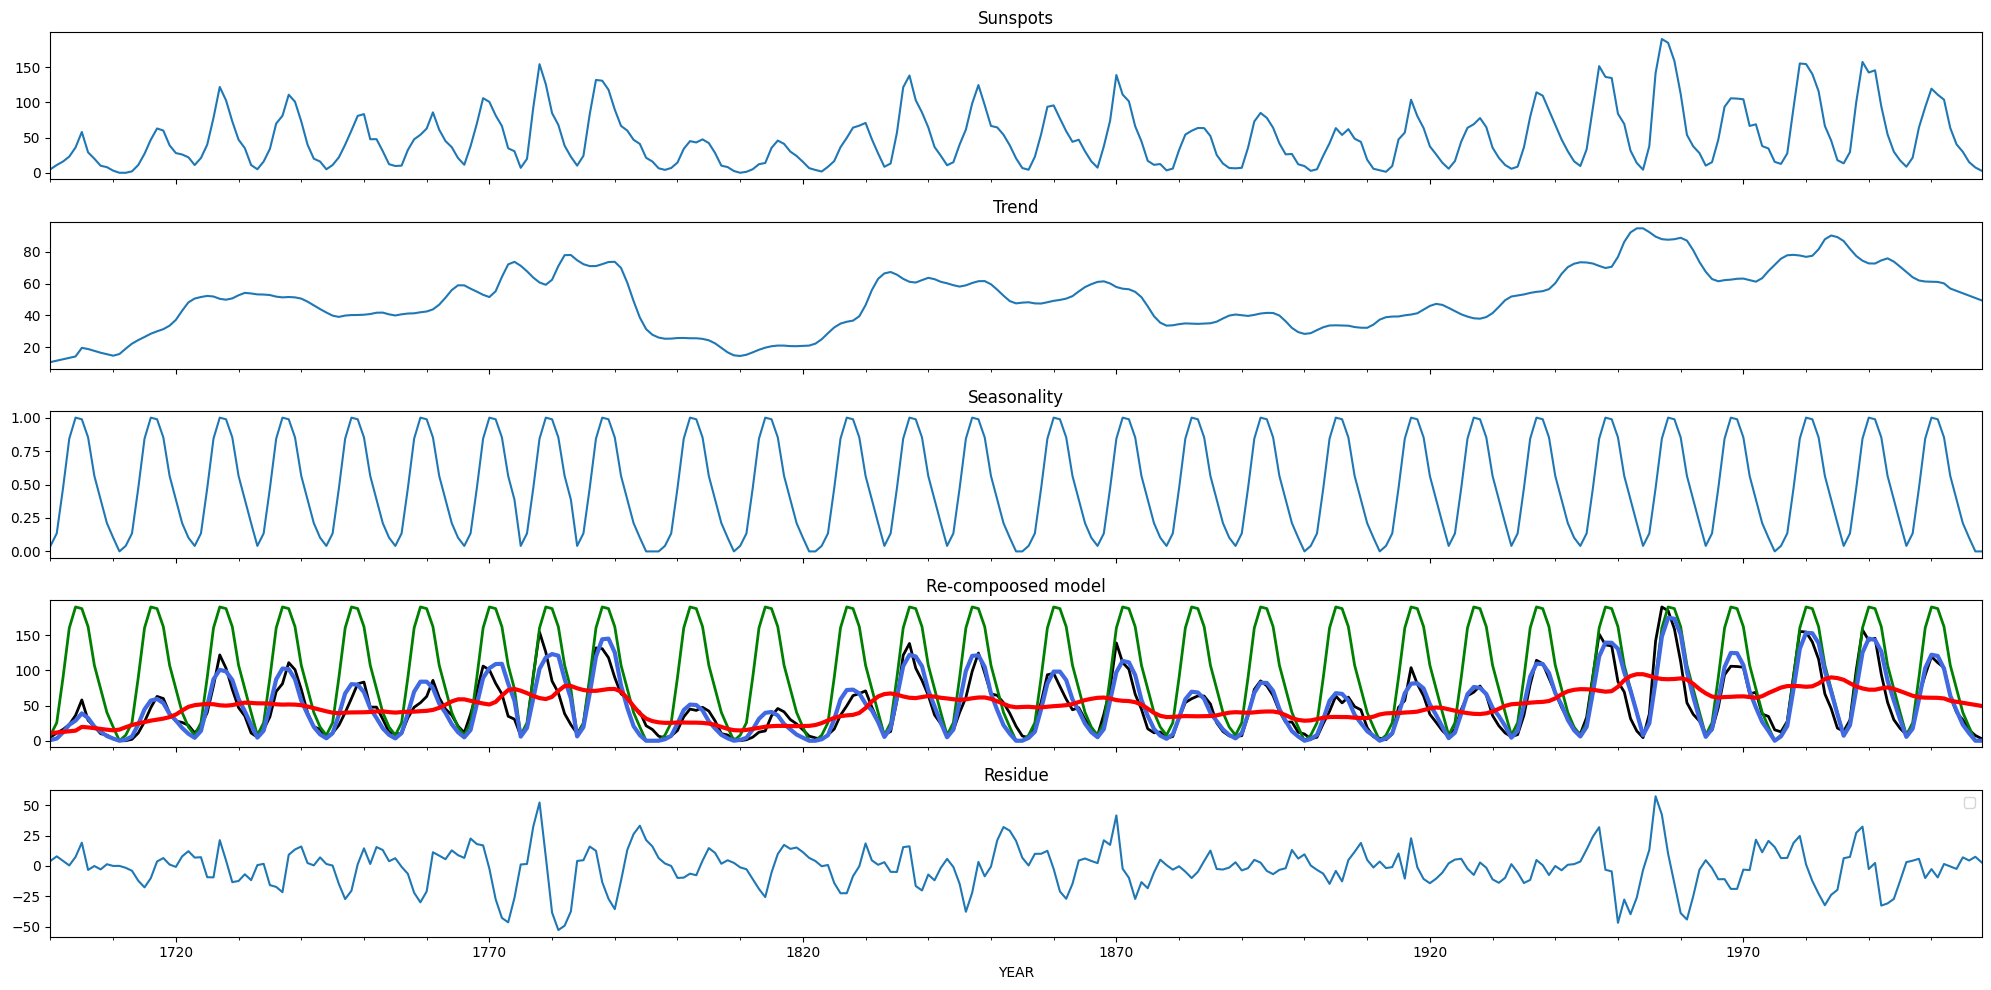

In [27]:
fig, axs = plt.subplots(nrows=5, ncols=1, sharex=True, figsize=(20, 10))
ss['SUNACTIVITY'].plot(ax = axs[0], title = 'Sunspots') # Sunspots
trend.plot(ax = axs[1], title = 'Trend') # Trend
seasonal.plot(ax=axs[2], title = "Seasonality") # seasonality
# re-composed model
ss['SUNACTIVITY'].plot(ax = axs[3], title = 'Re-compoosed model', color='black', linewidth=2)
pd.Series(seasonal*max(ss['SUNACTIVITY'])).plot(ax=axs[3], color='green', linewidth=2)
season_and_trend.plot(ax=axs[3], label='trend & seasonal', color='royalblue', linewidth=3)
trend.plot(ax=axs[3], label='trend', color='red',linewidth=3)

residue.plot(ax=axs[4], title = 'Residue') # residuals

plt.legend()
plt.tight_layout()
plt.savefig('images/sunspots_decomposition and model.png', dpi=300)
plt.show()

Note that the trend still has some nonlinear fluctuations in it; it seems there might be a second form of seasonality going on (can almost be divided into three 'chunks' of relativley higher and relatively lower elevation. If we spent more time we could probably create a more complicated model that treated those chunks as seasons, and probably reduce residue from the model.

# Air travel

In [28]:
air = pd.read_csv('data/AirPassengers.csv')

Need to reset the index of `air`, then use `seasonal_decompose` to examine its decomposed elements

In [29]:
air = air.set_index(pd.to_datetime(air.Month)).drop('Month', axis=1).rename({'#Passengers': 'Passengers'}, axis=1)
air

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


<Axes: xlabel='Month'>

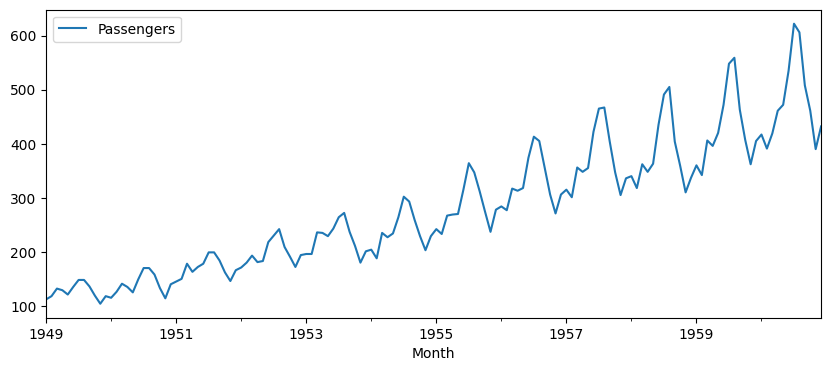

In [30]:
air.plot(figsize = (10, 4))

Looks the same as the example data

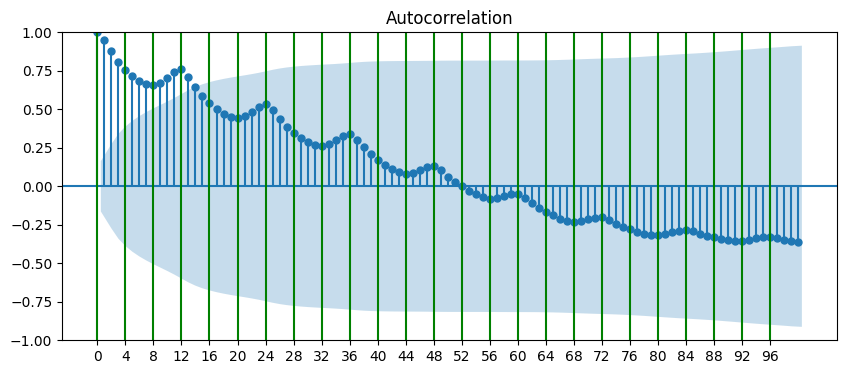

In [31]:
# find length of periods
_, ax = plt.subplots(figsize=(10,4))
tsaplots.plot_acf(air,lags=100, ax=ax)
ax.set_xticks(range(0, 100, 4))
for vertline in range(0, 100, 4):
    plt.axvline(x=vertline, color = 'green')
plt.show()

Very clear peaks and somewhat clear troughs every 12 months; which corresponds to yearly cycle--this makes sense. Based on the observed data, a multiplicative model would be best for air passengers, because the magnitude of the seasons seem to increase with the time series data. However, I will compute both and examine the RMSE for both.

In [32]:
air_period = 12
decomp_air_mult = seasonal_decompose(air['Passengers'], model = 'multiplicative', period = air_period)
decomp_air_add = seasonal_decompose(air['Passengers'], model = 'additive', period = air_period)

<Axes: xlabel='Month'>

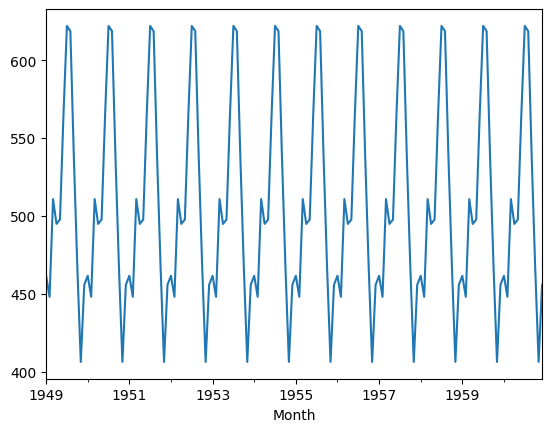

In [33]:
resized_seasonality_air_mult = (decomp_air_mult.seasonal/max(decomp_air_mult.seasonal))*max(decomp_air_mult.observed)
resized_seasonality_air_mult.plot()

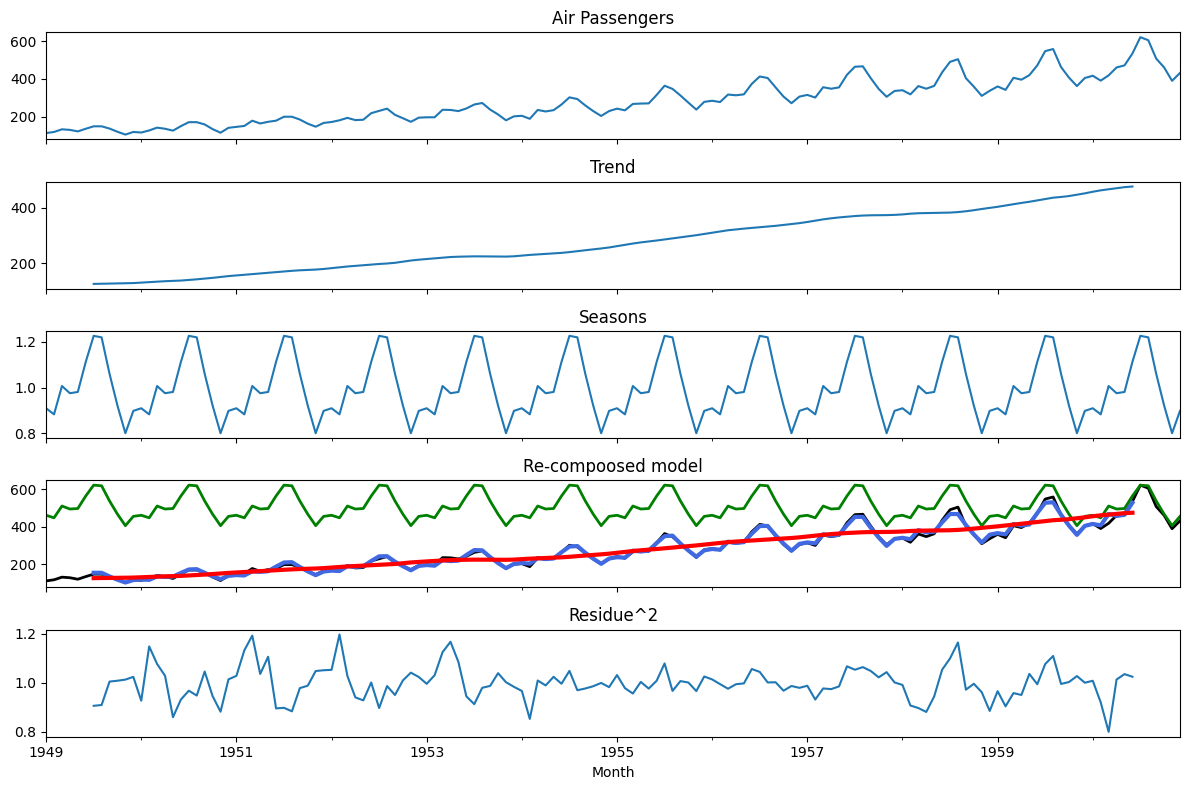

In [34]:
#decomp_air_mult
resized_seasonality_air_mult = (decomp_air_mult.seasonal/max(decomp_air_mult.seasonal))*max(decomp_air_mult.observed)
season_and_trend_air_mult = (decomp_air_mult.trend * decomp_air_mult.seasonal).dropna()

fig, axs = plt.subplots(ncols = 1, nrows = 5, sharex = True, figsize = (12,8))
decomp_air_mult.observed.plot(ax = axs[0], title ='Air Passengers')
decomp_air_mult.trend.plot(ax = axs[1], title ='Trend')
decomp_air_mult.seasonal.plot(ax = axs[2], title ='Seasons')

# re-composed model
decomp_air_mult.observed.plot(ax = axs[3], title = 'Re-compoosed model', color='black', linewidth=2)
resized_seasonality_air_mult.plot(ax=axs[3], label = 'seasonality (resized)', color = 'green', linewidth=2)
season_and_trend_air_mult.plot(ax=axs[3], label='trend & seasonal', color='royalblue', linewidth=3)
decomp_air_mult.trend.plot(ax=axs[3], label='trend', color='red',linewidth=3)

# residue
(decomp_air_mult.resid**2).plot(ax = axs[4], title ='Residue^2')

plt.tight_layout()
plt.savefig('images/air_multiplicative_summary.png', dpi=300)
plt.show()

In [35]:
# mult RMSE
mult_RMSE = pd.DataFrame(decomp_air_mult.resid).dropna()**2
mult_RMSE = np.sqrt(mult_RMSE.sum())
mult_RMSE

resid    11.475219
dtype: float64

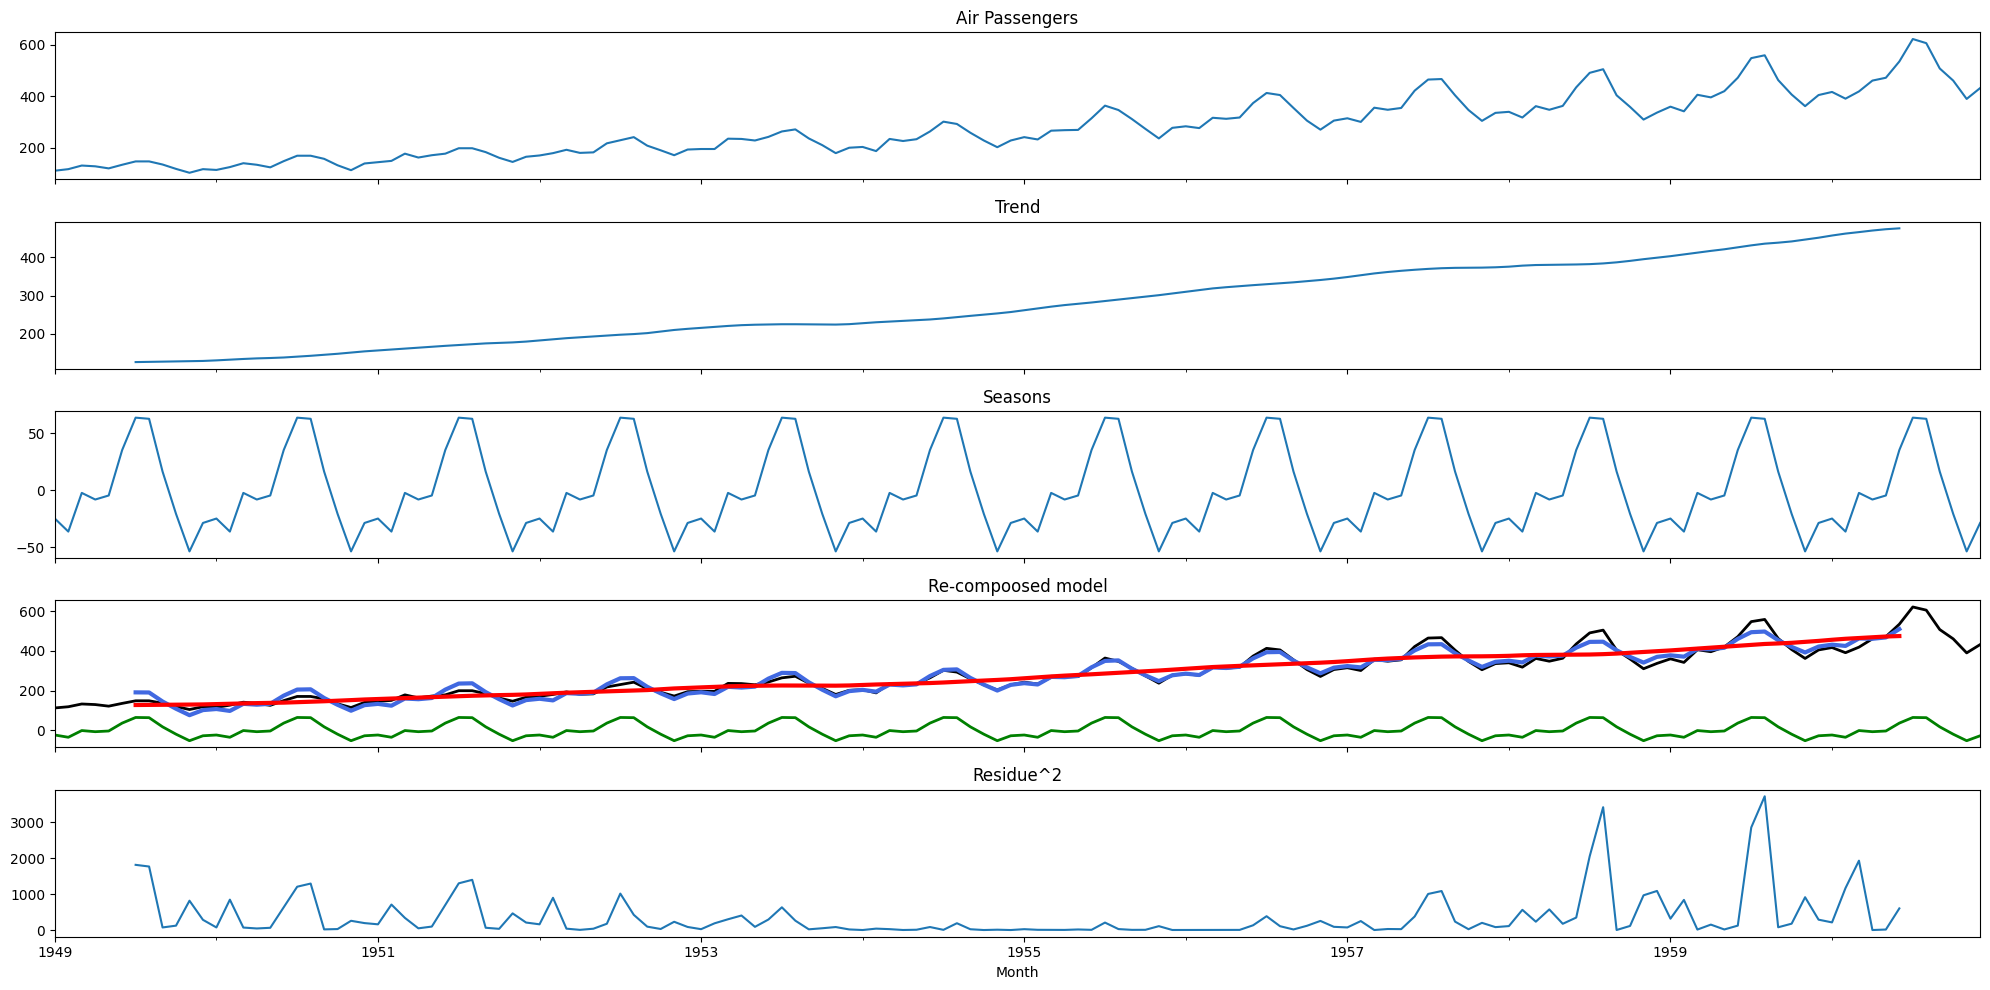

In [36]:
#decomp_air_add
season_and_trend_air_add = (decomp_air_add.trend + decomp_air_add.seasonal).dropna()

fig, axs = plt.subplots(ncols = 1, nrows = 5, sharex = True, figsize = (20,10))
decomp_air_add.observed.plot(ax = axs[0], title ='Air Passengers')
decomp_air_add.trend.plot(ax = axs[1], title ='Trend')
decomp_air_add.seasonal.plot(ax = axs[2], title ='Seasons')
# re-composed model
decomp_air_add.observed.plot(ax = axs[3], title = 'Re-compoosed model', color='black', linewidth=2)
decomp_air_add.seasonal.plot(ax=axs[3], color = 'green', linewidth=2)
season_and_trend_air_add.plot(ax=axs[3], label='trend & seasonal', color='royalblue', linewidth=3)
decomp_air_add.trend.plot(ax=axs[3], label='trend', color='red',linewidth=3)

# residue
(decomp_air_add.resid**2).plot(ax = axs[4], title ='Residue^2')

plt.tight_layout()
plt.savefig('images/air_additive_summary.png', dpi=300)
plt.show()

In [37]:
# add RMSE
add_RMSE = pd.DataFrame(decomp_air_add.resid).dropna()**2
add_RMSE = np.sqrt(add_RMSE.sum())
add_RMSE

resid    221.530751
dtype: float64